In [220]:
# add this to read data because using google colab, then need to change file paths

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# project directory within Google drive
mydir = 'gdrive/My Drive/courses/AC209a/final project offline/'

# custom stype
plt.style.use(mydir+'code/ac209a.mplstyle')

In [0]:
# import libraries

import random
random.seed(50) # set this so results can be reproduced

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import keras 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

%matplotlib inline

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [0]:
angs = ['hf','ab','ir'] # response: ground truth mocap angles (3 DOF)

n_sens = 6
sens = ['s'+str(k) for k in range(1,n_sens+1)] # predictors: sensor labels s1 through s6

#Data selection

In [0]:
# # OPTION 1: SINGLE DATA SET (for quick testing purposes)

# # since for LSTM order matters, avoid pooled data (because not sure what will happen at discontinuities when concatenating)
# # try the longest file for now (m1 t2a)

# # load the data and set column headers
# df = pd.read_csv(mydir+'data/M1_t2A.txt', header=None, names=['time','s1','s2','s3','s4','s5','s6','hf','ab','ir'])
# display(df.head())
# print(df.shape)

# # separate out predictors X from response y
# X_raw = df[sens]
# y = df[angs]

# time = df.time # just for plotting purposes

# # train-test split over time (NOT RANDOMIZED)
# X_train_raw, X_test_raw, y_train, y_test, t_train, t_test = train_test_split(X_raw,y,time,shuffle=False,test_size=0.5)

In [0]:
# OPTION 2: POOLED - use sets 1 and 2 as train, set 3 as test

dfs = [] # list of dataframes
t_offset = 0

for n in [1,2]:
  for t in ['A','B','C']:
    filepath = mydir+'data/M1_t'+str(n)+t+'.txt'
    df_temp = pd.read_csv(filepath, header=None, names=['time','s1','s2','s3','s4','s5','s6','hf','ab','ir'])
    df_temp.time = df_temp.time + t_offset
    t_offset = df_temp.time.values[-1]
    dfs.append(df_temp)

df_train_pooled = pd.concat(dfs, ignore_index=True)

# repeat to build test set

dfs = []

for t in ['A','B','C']:
  filepath = mydir+'data/M1_t3'+t+'.txt'
  df_temp = pd.read_csv(filepath, header=None, names=['time','s1','s2','s3','s4','s5','s6','hf','ab','ir'])
  df_temp.time = df_temp.time + t_offset
  t_offset = df_temp.time.values[-1]
  dfs.append(df_temp)
  
df_test_pooled = pd.concat(dfs, ignore_index=True)
    
# separate out predictors X from response y, set train and test

X_train_raw = df_train_pooled[sens]
y_train = df_train_pooled[angs]
t_train = df_train_pooled.time

X_test_raw = df_test_pooled[sens]
y_test = df_test_pooled[angs]
t_test = df_test_pooled.time

In [0]:
# # OPTION 3: Yichu's train/test set
# # all files pooled, every 20 points, first 80% as training set and last 20% as test set.
# # Added features: previous terms, 1st and 2nd derivative, polynomialFeatures of 3

# X_train = pd.read_csv(mydir+'data/X_train.csv')
# X_test = pd.read_csv(mydir+'data/X_test.csv')
# y_train = pd.read_csv(mydir+'data/y_train.csv')
# y_test = pd.read_csv(mydir+'data/y_test.csv')

# display(X_train.head())
# display(y_test.head())

#Data setup

In [227]:
# verify sizes of train and test sets (before processing)
print(X_train_raw.shape)
print(y_train.shape)
display(X_train_raw.head())

print(X_test_raw.shape)
print(y_test.shape)
display(X_test_raw.head())

(79690, 6)
(79690, 3)


s1      s2      s3      s4      s5      s6
0  205.33  176.98  225.10  208.81  152.47  164.64
1  205.32  177.00  225.06  208.67  152.41  164.62
2  205.31  177.02  225.02  208.53  152.36  164.60
3  205.30  177.03  225.00  208.45  152.34  164.59
4  205.30  177.04  224.98  208.38  152.31  164.59

(38586, 6)
(38586, 3)


s1      s2      s3      s4      s5      s6
0  208.22  180.05  229.88  202.40  150.06  165.02
1  208.25  180.04  229.89  202.42  150.08  165.02
2  208.29  180.04  229.91  202.44  150.09  165.02
3  208.31  180.04  229.92  202.45  150.10  165.02
4  208.32  180.04  229.93  202.46  150.11  165.02

In [0]:
# downsample data
# if you don't want to downsample just set f=1

f = 10 # factor of downsampling

X_train_raw_ds = X_train_raw.iloc[::f,:]
X_test_raw_ds = X_test_raw.iloc[::f,:]

y_train = y_train.iloc[::f,:]
y_test = y_test.iloc[::f,:]

t_train = t_train.iloc[::f,]
t_test = t_test.iloc[::f]

In [229]:
# add sensor change rates

tvals = t_train

for s in sens:
  
  svals = X_train_raw_ds[s].values

  dt = np.diff(tvals)
  ds = np.diff(svals)

  dsdt = ds/dt

  dsdt = np.concatenate((np.zeros(1),dsdt)) # pad to match length
  
  # save to dataframe
  label = 'd'+s
  X_train_raw_ds[label] = pd.Series(dsdt, index=X_train_raw_ds.index)


# repeat for test

tvals = t_test

for s in sens:
  
  svals = X_test_raw_ds[s].values

  dt = np.diff(tvals)
  ds = np.diff(svals)

  dsdt = ds/dt

  dsdt = np.concatenate((np.zeros(1),dsdt)) # pad to match length
  
  # save to dataframe
  label = 'd'+s
  X_test_raw_ds[label] = pd.Series(dsdt, index=X_test_raw_ds.index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
# normalize sensor data
scaler = MinMaxScaler() # default will scale 0 to 1
scaler.fit(X_train_raw_ds) # fit scaler on training data
X_train = scaler.transform(X_train_raw_ds)
X_test = scaler.transform(X_test_raw_ds)

In [231]:
# verify sizes of train and test sets (final)
print(X_train.shape)
print(y_train.shape)
display(X_train)

print(X_test.shape)
print(y_test.shape)
display(X_test)

(7969, 12)
(7969, 3)


array([[0.2698212 , 0.        , 0.47994908, ..., 0.79912748, 0.70426771,
        0.60297412],
       [0.26891819, 0.00862999, 0.46976448, ..., 0.72218873, 0.66008735,
        0.59030515],
       [0.27018241, 0.01833873, 0.45798854, ..., 0.71531321, 0.65376315,
        0.59307158],
       ...,
       [0.33592198, 0.17313916, 0.52450668, ..., 0.79988038, 0.70186826,
        0.59979847],
       [0.33592198, 0.17313916, 0.52514322, ..., 0.79982062, 0.70316321,
        0.60005051],
       [0.33592198, 0.17313916, 0.52577976, ..., 0.79912748, 0.70426771,
        0.60198386]])

(3859, 12)
(3859, 3)


array([[0.32201553, 0.16558792, 0.63208148, ..., 0.79912748, 0.70426771,
        0.60297412],
       [0.32671122, 0.1639698 , 0.63621897, ..., 0.81021775, 0.71862633,
        0.60297412],
       [0.3314069 , 0.16343042, 0.640993  , ..., 0.81110095, 0.71885792,
        0.60396437],
       ...,
       [0.34386852, 0.19147789, 0.63017187, ..., 0.80289196, 0.70666716,
        0.60297412],
       [0.34350731, 0.19093851, 0.63049013, ..., 0.80060775, 0.7066265 ,
        0.60297412],
       [0.34350731, 0.19093851, 0.63049013, ..., 0.80063327, 0.70546744,
        0.60297412]])

# Plot data

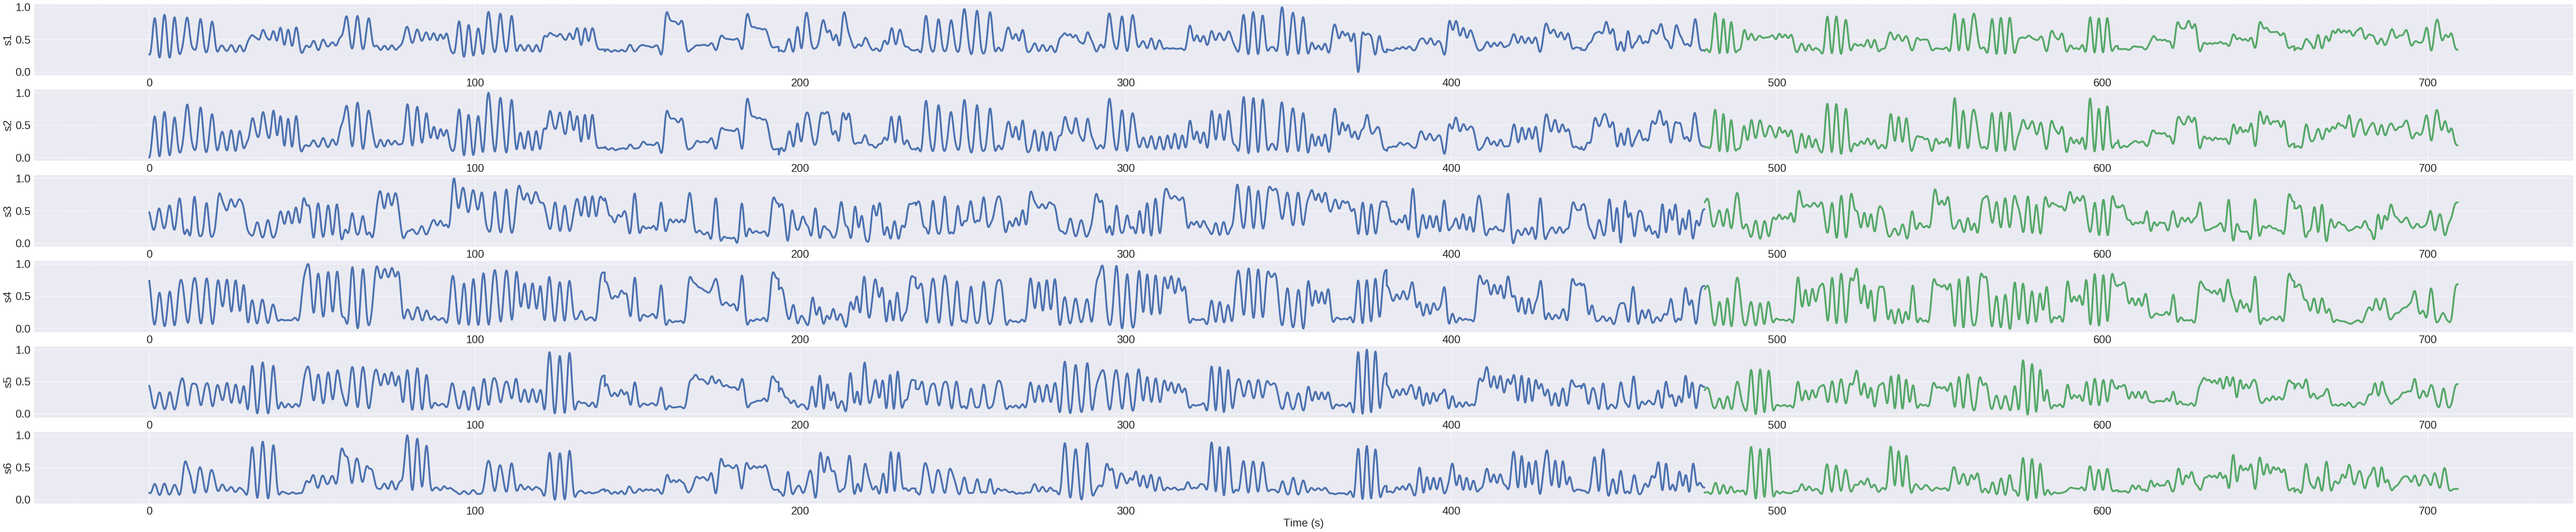

In [241]:
# plot predictors and response variables over time

fig, ax = plt.subplots(n_sens, 1, figsize=(99,20))

for k in range(0,n_sens):
    ax[k].plot(t_train,X_train[:,k])
    ax[k].plot(t_test,X_test[:,k])
    ax[k].set_ylabel(sens[k])
    
ax[-1].set_xlabel('Time (s)');

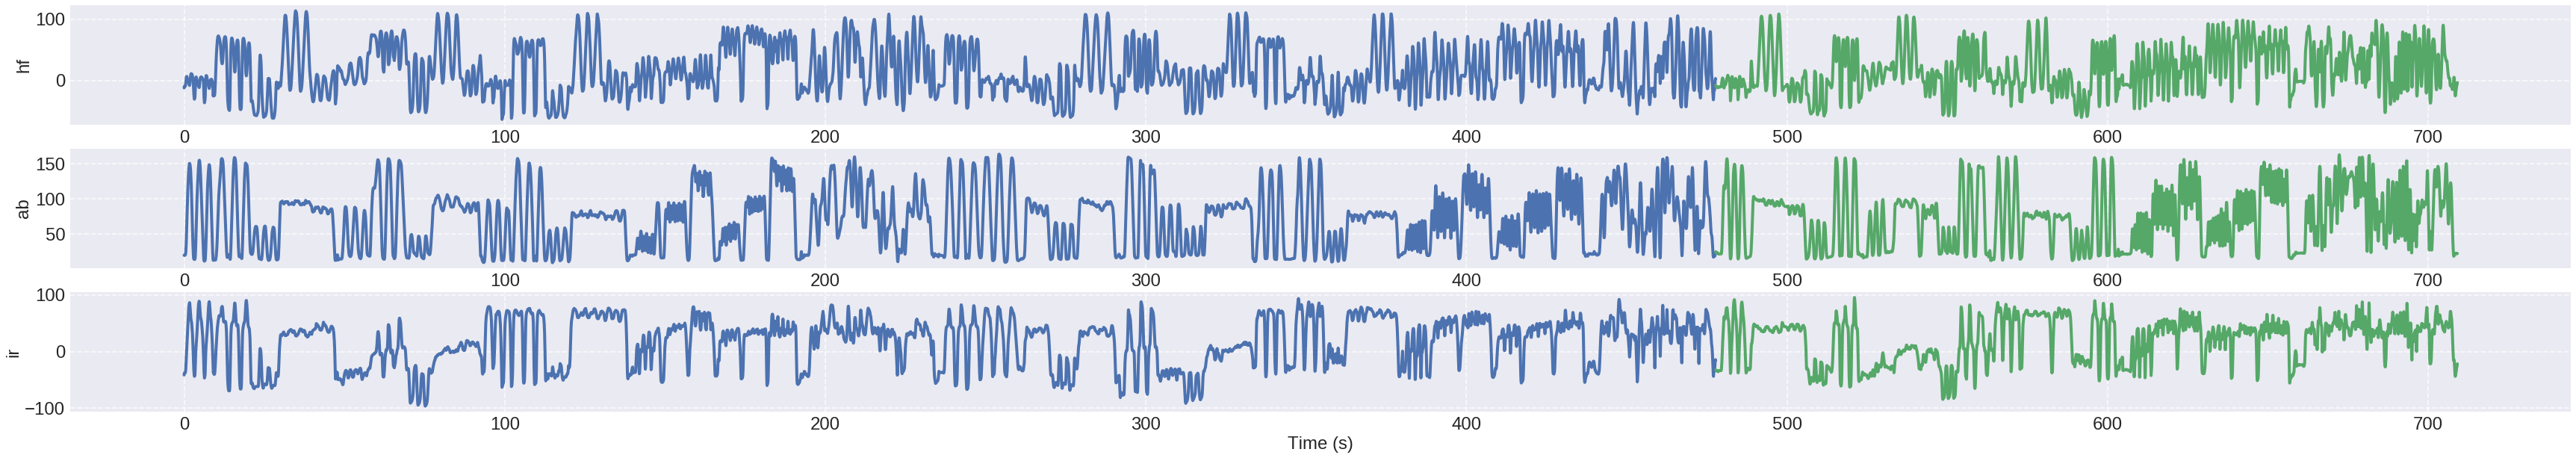

In [249]:

fig, ax = plt.subplots(3, 1, figsize=(60,10))

for k in range(0,3):
    ax[k].plot(t_train,y_train[angs[k]])
    ax[k].plot(t_test,y_test[angs[k]])
    ax[k].set_ylabel(angs[k])
    
ax[-1].set_xlabel('Time (s)');

# Standard NN

In [234]:
# build NN structure

# n timepoints
# inputs are nx6
# outputs are nx3

model = Sequential()
model.add(Dense(100, input_dim=12, activation='tanh')) # hidden layer 1
model.add(Dense(200, activation='tanh')) # hidden layer 2
model.add(Dropout(0.2)) # dropout layer to help with overfitting
model.add(Dense(3, kernel_initializer='normal', activation='linear')) # output layer

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               1300      
_________________________________________________________________
dense_21 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 603       
Total params: 22,103
Trainable params: 22,103
Non-trainable params: 0
_________________________________________________________________


In [235]:
model_history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, verbose=1)

Train on 6375 samples, validate on 1594 samples
Epoch 1/100
6375/6375 [==============================] - 4s 565us/step - loss: 2499.4318 - val_loss: 1703.1983
Epoch 2/100
6375/6375 [==============================] - 1s 185us/step - loss: 1848.0567 - val_loss: 1442.9526
Epoch 3/100
6375/6375 [==============================] - 1s 183us/step - loss: 1585.1698 - val_loss: 893.6157
Epoch 4/100
6375/6375 [==============================] - 1s 179us/step - loss: 966.0027 - val_loss: 657.9483
Epoch 5/100
6375/6375 [==============================] - 1s 183us/step - loss: 837.4068 - val_loss: 614.9128
Epoch 6/100
6375/6375 [==============================] - 1s 184us/step - loss: 774.6220 - val_loss: 558.0791
Epoch 7/100
6375/6375 [==============================] - 1s 182us/step - loss: 695.1523 - val_loss: 455.7128
Epoch 8/100
6375/6375 [==============================] - 1s 190us/step - loss: 586.8512 - val_loss: 380.9901
Epoch 9/100
6375/6375 [==============================] - 1s 184us/step - lo

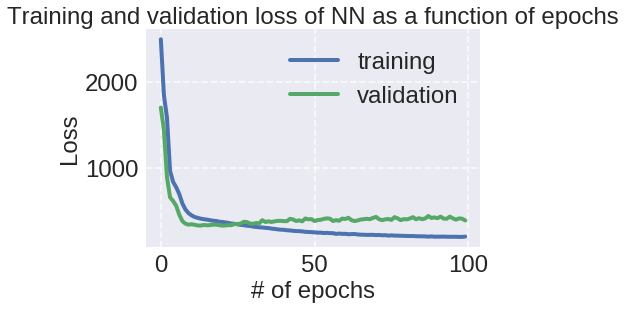

In [236]:
# plot training progress (via loss func) over epochs
fig,ax = plt.subplots(1,1)
ax.plot(model_history.epoch,model_history.history['loss'],label='training')
ax.plot(model_history.epoch,model_history.history['val_loss'],label='validation')

ax.set_xlabel('# of epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and validation loss of NN as a function of epochs')

ax.legend();

In [0]:
# make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

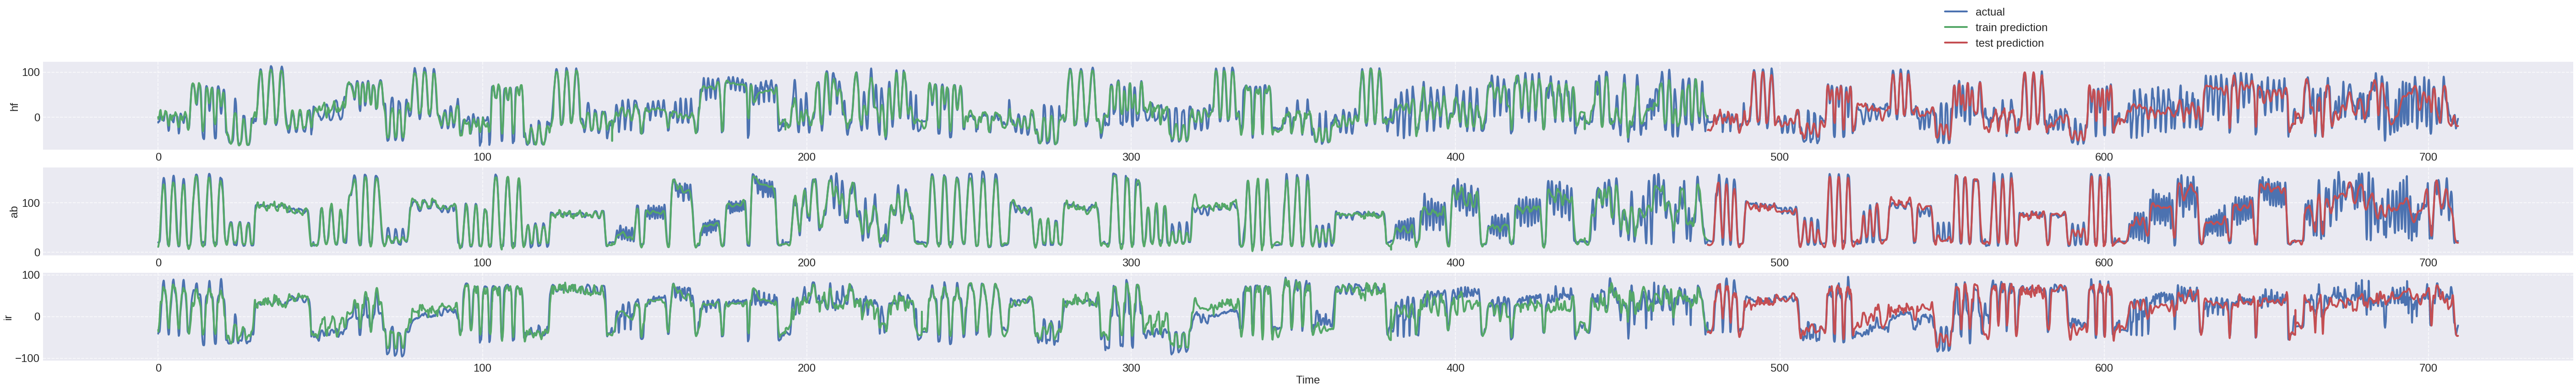

In [238]:
# plot results

fig, axs = plt.subplots(3, 1,figsize=(99,12))

for k,ax in enumerate(axs):
    
    # plot actual ground truth
#     ax.plot(df.time,df[angs[k]],label='actual')
    ax.plot(pd.concat([t_train,t_test]),pd.concat([y_train,y_test])[angs[k]],label='actual')
    
    # plot train set prediction
    ax.plot(t_train,y_pred_train[:,k],label='train prediction')
    
    # plot test set prediction
    ax.plot(t_test,y_pred_test[:,k],label='test prediction')
    
    ax.set_ylabel(angs[k])

axs[-1].set_xlabel('Time')
axs[0].legend(loc=(0.75,1.1));

In [239]:
model.evaluate(X_test, y_test) # prints loss function on test (currently, MSE)

3859/3859 [==============================] - 0s 102us/step


335.8110637501689

In [240]:
r2_report = 'Train: '

for k, ang in enumerate(angs):
  r2_report = r2_report + ang + ' ' + str(r2_score(y_train.values[:,k],y_pred_train[:,k])) + ' // '
  
print(r2_report)

r2_report = 'Test: '

for k, ang in enumerate(angs):
  r2_report = r2_report + ang + ' ' + str(r2_score(y_test.values[:,k],y_pred_test[:,k])) + ' // '
  
print(r2_report)

Train: hf 0.8818020647411097 // ab 0.9334365053860435 // ir 0.8368074925696078 // 
Test: hf 0.7297862155990573 // ab 0.8571284122573701 // ir 0.7341002896679996 // 


# LSTM

In [242]:
# build LSTM NN

# n timepoints
# inputs are nx6
# outputs are nx3

# keras recurrent layers (of which LSTM is one type) expect input dimensions as follows:
# (batch_size, timesteps, input_dim)

n_batch = 5 # train set size is 12079 so size of 500 is ~25 passes per epoch
N_past = 5
n_LSTM = 20 # of neurons in LSTM layer

# reshape data to have timestep dimension

# X_train currently has shape (# of observations, # of features/sensors)

def data_addpast(X,n_pastwindow):
  
  X_reshaped = np.zeros((X.shape[0],n_pastwindow,X.shape[1]))
  
  for k in range(n_pastwindow):
    X_reshaped[:,k,:] = np.roll(X,k*-1,axis=0)
   
  return X_reshaped

X_train_reshaped = data_addpast(X_train,N_past)
X_test_reshaped = data_addpast(X_test,N_past)

# trim away rows where window rolls over
X_train_reshaped = X_train_reshaped[:-(N_past+1),:,:]
X_test_reshaped = X_test_reshaped[:-(N_past+1),:,:]
y_train_reshaped = y_train.iloc[:-(N_past+1)].values
y_test_reshaped = y_test.iloc[:-(N_past+1)].values
t_train_reshaped = t_train.iloc[:-(N_past+1)].values
t_test_reshaped = t_test.iloc[:-(N_past+1)].values

# check shapes
print(X_train_reshaped.shape)
print(y_train_reshaped.shape)

(7963, 5, 12)
(7963, 3)


In [243]:

model2 = Sequential()
model2.add(LSTM(n_LSTM, input_shape=(N_past,n_sens*2), unroll=False)) # LSTM layer
model2.add(Dropout(0.2))
model2.add(Dense(50, activation='tanh'))
model2.add(Dense(3, kernel_initializer='normal', activation='linear')) # output layer

model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 20)                2640      
_________________________________________________________________
dropout_11 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 153       
Total params: 3,843
Trainable params: 3,843
Non-trainable params: 0
_________________________________________________________________


In [244]:
# train the NN

model_history2 = model2.fit(X_train_reshaped, y_train_reshaped, epochs=30, batch_size=n_batch, validation_split=0.1, verbose=1, shuffle=False)

Train on 7166 samples, validate on 797 samples
Epoch 1/30
7166/7166 [==============================] - 33s 5ms/step - loss: 2361.8291 - val_loss: 1815.3323
Epoch 2/30
7166/7166 [==============================] - 30s 4ms/step - loss: 1760.1575 - val_loss: 1525.8264
Epoch 3/30
7166/7166 [==============================] - 30s 4ms/step - loss: 1540.7264 - val_loss: 1106.0512
Epoch 4/30
7166/7166 [==============================] - 30s 4ms/step - loss: 1028.7381 - val_loss: 809.6668
Epoch 5/30
7166/7166 [==============================] - 30s 4ms/step - loss: 855.7780 - val_loss: 715.2795
Epoch 6/30
7166/7166 [==============================] - 30s 4ms/step - loss: 783.4627 - val_loss: 675.5497
Epoch 7/30
7166/7166 [==============================] - 30s 4ms/step - loss: 751.0486 - val_loss: 644.4537
Epoch 8/30
7166/7166 [==============================] - 30s 4ms/step - loss: 720.4553 - val_loss: 607.3744
Epoch 9/30
7166/7166 [==============================] - 30s 4ms/step - loss: 662.2511 - va

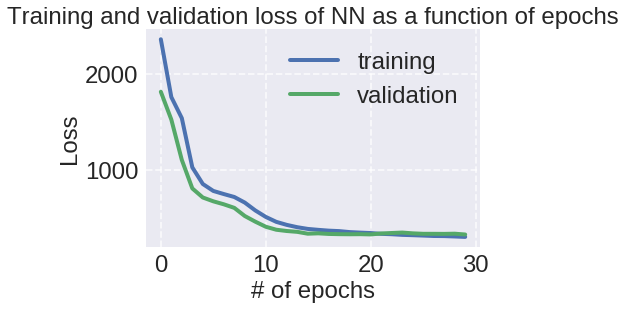

In [245]:
# plot training progress (via loss func) over epochs
fig,ax = plt.subplots(1,1)
ax.plot(model_history2.epoch,model_history2.history['loss'],label='training')
ax.plot(model_history2.epoch,model_history2.history['val_loss'],label='validation')

ax.set_xlabel('# of epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and validation loss of NN as a function of epochs')

ax.legend();

In [246]:
# make predictions

y_pred_train = model2.predict(X_train_reshaped)
y_pred_test = model2.predict(X_test_reshaped)

print('Score:')

print(model2.evaluate(X_test_reshaped, y_test_reshaped))

Score:
3853/3853 [==============================] - 1s 245us/step
382.23176727374124


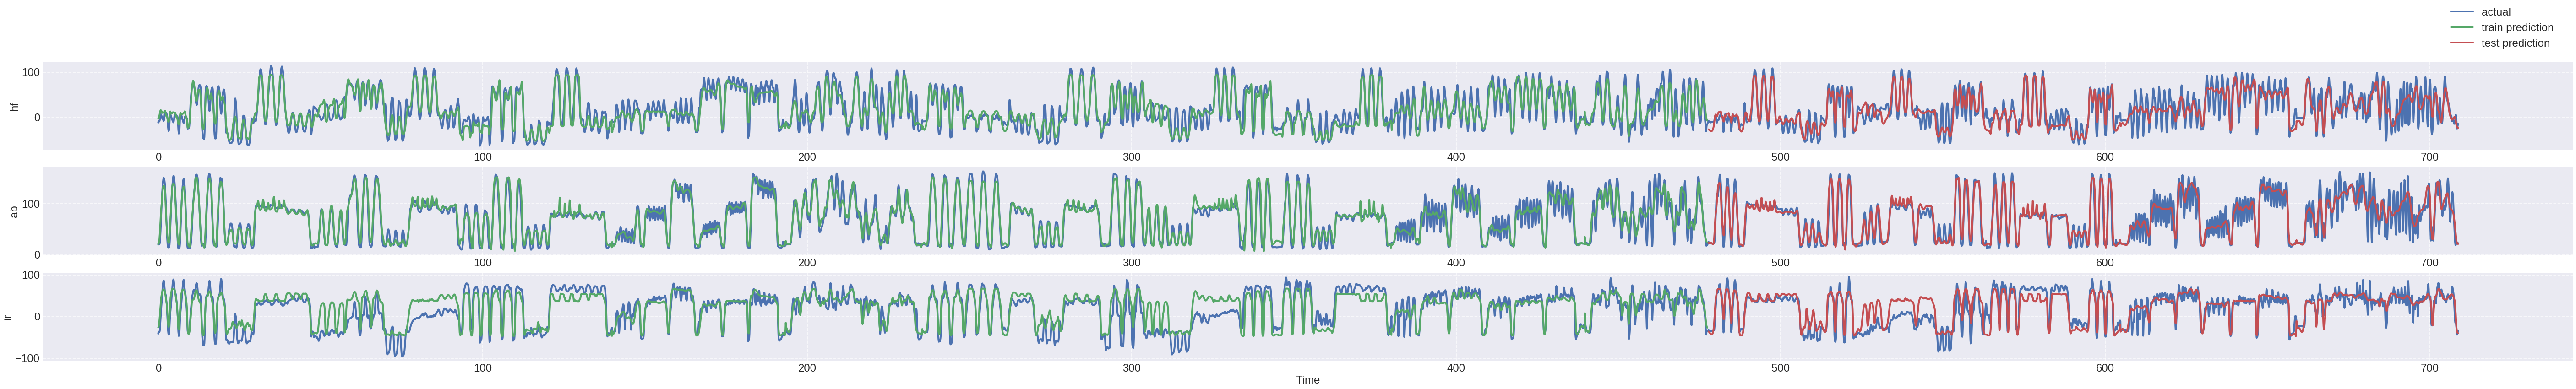

In [247]:
# plot results

fig, axs = plt.subplots(3, 1,figsize=(99,12))

for k,ax in enumerate(axs):
    
    # plot actual ground truth
    ax.plot(np.concatenate([t_train_reshaped,t_test_reshaped]),np.concatenate([y_train_reshaped,y_test_reshaped])[:,k],label='actual')
    
    # plot train set prediction
    ax.plot(t_train_reshaped,y_pred_train[:,k],label='train prediction')
    
    # plot test set prediction
    ax.plot(t_test_reshaped,y_pred_test[:,k],label='test prediction')
    
    ax.set_ylabel(angs[k])

axs[-1].set_xlabel('Time')
axs[0].legend(loc=(0.95,1.1));

In [248]:
r2_report = 'Train: '

for k, ang in enumerate(angs):
  r2_report = r2_report + ang + ' ' + str(r2_score(y_train_reshaped[:,k],y_pred_train[:,k])) + ' // '
  
print(r2_report)

r2_report = 'Test: '

for k, ang in enumerate(angs):
  r2_report = r2_report + ang + ' ' + str(r2_score(y_test_reshaped[:,k],y_pred_test[:,k])) + ' // '
  
print(r2_report)

Train: hf 0.8352022248053942 // ab 0.9105047519829494 // ir 0.6993961170876826 // 
Test: hf 0.7173217634708138 // ab 0.8333828511386261 // ir 0.6781037588002565 // 
